In [2]:
using CSV, DataFrames, DataFramesMeta, Missings
using StatsBase, Statistics, MatrixLM
using Random, Distributions, StatsModels
using LinearAlgebra
using FreqTables, Plots, StatsPlots

In [3]:
begin
	######################
	# External functions #
	######################
	include(joinpath(@__DIR__, "..", "src","mLinearModel.jl" ));
	include(joinpath(@__DIR__,"..", "src","myPlots.jl" ));

end;

slctFishOil = "true"  # set value of fish oil supplementation

"true"

In [4]:
#############
# Load data #
#############

# Load look up table for lipids
LipidsXref = realpath((@__DIR__)*"/../data/data_processed/inl2b_Lipids_Xref.csv")
dfLipidsXref = DataFrame(CSV.File(LipidsXref));

# Load data set
fileLipids = realpath((@__DIR__)*"/../data/data_processed/inl2b_Lipids.csv")
dfLipids = DataFrame(CSV.File(fileLipids));

################
# Filter cases #
################
# true => unpaired
# false => paired (rechallenge)
isunpairFlag = true;
df = getCases(dfLipids, isunpaired = isunpairFlag);

# Check to filter none fish oil users 
hasFishOil = eval(Meta.parse(slctFishOil));

if !hasFishOil
    # Get only individuals with no fish oil
    filter!(row-> row.FishOil == "no" ,df);
end


# standardize lipids mass-to-charge ratio
funStandardize!(df, isunpaired = isunpairFlag);

In [5]:
begin
	########################
	# Load Z raw all valid #
	########################

	# Get Zmat
	dfZrawAll =  DataFrame(CSV.File("../data/data_processed/ZmatRawAll.csv"))

	classLipids = freqtable(dfZrawAll.Class)
	DataFrame(Class = names(classLipids, 1), Count = collect(classLipids[:]))

end

Row,Class,Count
,String,Int64
1,Ceramide 1-phosphates [SP0205],11
2,Ceramide phosphocholines (sphingomyelins) [SP0301],158
3,Ceramides [SP02],93
4,Cholesterol and derivatives [ST0101],1
5,Diacylglycerols [GL0201],45
6,Dimethylphosphatidylethanolamine,15
7,Fatty acyl carnitines [FA0707],25
8,Glycerophosphates [GP10],53
9,Glycerophosphocholines [GP01],410


In [6]:
begin
	#######################
	# Plotting attributes #
	#######################
	myfont = "Helvetica"
	mytitlefontsize = 12
end;

# Pluto UI widgets values

slctFishOil = "true"  
rdZ = "Triglycerides"
rdX = "false"

"false"

In [7]:
begin
	# Get Zmat
	fZrawAll = "../data/data_processed/ZmatRawAll.csv"
	fZrawTG = "../data/data_processed/ZmatRawTG.csv"
	fZrawP = "../data/data_processed/ZmatRawPhos.csv"
	fZrawPC = "../data/data_processed/ZmatRawPhosPC.csv"
	# fZrawPE = "../../data/dataprocessed/ZmatRawPhosPE.csv"

	fZraw = Dict("All"=> fZrawAll,
				 "Triglycerides"=> fZrawTG,
				 "Phospholipids"=> fZrawP,
				 "Phospholipids: PC"=> fZrawPC);

	dfZraw =  DataFrame(CSV.File(fZraw[rdZ]))
	dfZraw = dfZraw[findall(x -> [x] ⊆ names(df), dfZraw.lipID),:]

	m =  length(dfZraw.lipID); #ifelse(isunpairFlag, size(df)[2]-5, size(df)[2]-2)

	is4ways = eval(Meta.parse(rdX));

	# ZI is identity matrix
	ZI = convert(Array{Float64, }, collect(I(m)));
	CoefZI, CIZI, TstatZI, varZI = getCoefs(df, ZI, responseSelection = dfZraw.lipID,
									 isunpaired = isunpairFlag,
									 hasFishOil = hasFishOil,
									 is4ways = is4ways);


	# Get X and Y
	if hasFishOil
		if is4ways
			X, Y = getXY4ways(df, responseSelection = dfZraw.lipID,
					 isunpaired = isunpairFlag);
			covarSelection = ["1"=> "CN-No Fish Oil (intercept)", "2"=> "CN-Fish Oil",
						  "3"=> "CS-No Fish Oil", "4"=> "CS-Fish Oil"]
		else
			X, Y = getXY(df, responseSelection = dfZraw.lipID,
					 isunpaired = isunpairFlag);
			covarSelection = ["1"=> "Intercept", "2"=> "SAMS status",
						  "3"=> "Fish Oil", "4"=> "Interaction SAMS-Fish Oil"]
		end
	else
		X, Y = getXYnoFishOil(df, responseSelection = dfZraw.lipID,
					 isunpaired = isunpairFlag);
		covarSelection = ["1"=> "Intercept", "2"=> "SAMS status"]
	end

	# nameX contains labels for plotting
	if isunpairFlag
		if is4ways
			namesX = ["CN-No Fish Oil" "CN-Fish Oil" "CS-No Fish Oil" "CS-Fish Oil"]
		else
    		namesX = ["Intercept" "SAMS status" "Fish Oil" "Interaction SAMS-Fish Oil"]
		end
	else
    	namesX = ["Intercept" "Interaction SAMS-Fish Oil"]
	end;
end;

In [8]:
# Two way frequency table Fish Oil vs Group

begin
	xTable = freqtable(df[:, [:FishOil, :Group]], :FishOil, :Group)
	matXfreq = collect(xTable[:,:]);
	matXfreq = vcat(matXfreq, sum(matXfreq, dims= 1))
	matXfreq = hcat(matXfreq, sum(matXfreq, dims= 2))
	dfFreqX = DataFrame(matXfreq, :auto)
	rename!(dfFreqX, Symbol.(vcat(names(xTable,2), "Total")))
	insertcols!(dfFreqX, 1, :_ => vcat("Fish Oil: ".*(names(xTable,1)), Symbol("Total")))
end

Row,_,CN,CS,Total
,Any,Int64,Int64,Int64
1,Fish Oil: no,39,26,65
2,Fish Oil: yes,15,18,33
3,Total,54,44,98


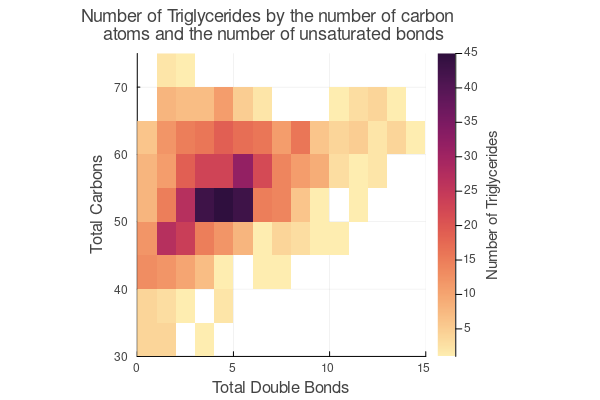

In [11]:
histogram2d(dfZraw.Total_DB, dfZraw.Total_C,
			c= :matter, aspectratio = 0.35, xlim = [0,15],
			colorbar_title = "Number of Triglycerides",
			xlabel= "Total Double Bonds", ylabel =  "Total Carbons",
			title = string("Number of ", rdZ, " by the number of carbon \n atoms and the number of unsaturated bonds \n"),
			fontfamily = myfont,
			titlefontsize = 12,
)

In [12]:
# Pluto UI widgets values

slct1 = "3" # set an initial value here
idxColXmat = parse(Int64,slct1);

In [14]:
# Pluto UI widgets values
slct2 = "factor(Total DB)" # set an initial value here

"factor(Total DB)"

In [17]:
begin
	dfZlinear = DataFrame(Total_C = dfZraw.Total_C,
				Total_DB = dfZraw.Total_DB,
                Interaction = dfZraw.Total_C.*dfZraw.Total_DB);

	# dfZtcdb = DataFrame(intercept = ones(Float64, size(dfZraw)[1]),
	#             # TotalC_0_45 = dfZraw.Total_C .< 40,
	# 			TotalC_45_55 = ((dfZraw.Total_C .>= 45) .& (dfZraw.Total_C .< 55))*1,
	# 			TotalC_55_65 = ((dfZraw.Total_C .>= 55) .& (dfZraw.Total_C .< 65))*1,
	# 			TotalC_65 = (dfZraw.Total_C .>= 65)*1,
	#             # TotalDB_0_3 = dfZraw.Total_DB .< 3,
	# 			TotalDB_3_6 = ((dfZraw.Total_DB .>= 3) .& (dfZraw.Total_DB .< 6))*1,
	# 			TotalDB_6_9 = ((dfZraw.Total_DB .>= 6) .& (dfZraw.Total_DB .< 9))*1,
	# 			TotalDB_9 = (dfZraw.Total_DB .>= 9)*1	);

	dfZtcdb = DataFrame(intercept = ones(Float64, size(dfZraw)[1]),
	            # TotalC_0_45 = dfZraw.Total_C .< 40,
	            TotalC_40_45 = ((dfZraw.Total_C .>= 40) .& (dfZraw.Total_C .< 45))*1,
	            TotalC_45_50 = ((dfZraw.Total_C .>= 45) .& (dfZraw.Total_C .< 50))*1,
	            TotalC_50_55 = ((dfZraw.Total_C .>= 50) .& (dfZraw.Total_C .< 55))*1,
	            TotalC_55_60 = ((dfZraw.Total_C .>= 55) .& (dfZraw.Total_C .< 60))*1,
	            TotalC_60_65 = ((dfZraw.Total_C .>= 60) .& (dfZraw.Total_C .< 65))*1,
	            TotalC_65_70 = ((dfZraw.Total_C .>= 65) .& (dfZraw.Total_C .< 70))*1,
	            TotalC_70 = (dfZraw.Total_C .>= 70)*1,
	            # TotalDB_0_3 = dfZraw.Total_DB .< 3,
	            TotalDB_3_6 = ((dfZraw.Total_DB .>= 3) .& (dfZraw.Total_DB .< 6))*1,
	            TotalDB_6_9 = ((dfZraw.Total_DB .>= 6) .& (dfZraw.Total_DB .< 9))*1,
	            TotalDB_9 = (dfZraw.Total_DB .>= 9)*1	);


	dfZtc = DataFrame(intercept = ones(Float64, size(dfZraw)[1]),
	            # TotalC_0_45 = dfZraw.Total_C .< 40,
				TotalC_40_45 = ((dfZraw.Total_C .>= 40) .& (dfZraw.Total_C .< 45))*1,
				TotalC_45_50 = ((dfZraw.Total_C .>= 45) .& (dfZraw.Total_C .< 50))*1,
				TotalC_50_55 = ((dfZraw.Total_C .>= 50) .& (dfZraw.Total_C .< 55))*1,
				TotalC_55_60 = ((dfZraw.Total_C .>= 55) .& (dfZraw.Total_C .< 60))*1,
				TotalC_60_65 = ((dfZraw.Total_C .>= 60) .& (dfZraw.Total_C .< 65))*1,
				TotalC_65_70 = ((dfZraw.Total_C .>= 65) .& (dfZraw.Total_C .< 70))*1,
				TotalC_70 = (dfZraw.Total_C .>= 70)*1  );

	# dfZdbcat = DataFrame(intercept = ones(Float64, size(dfZraw)[1]),
 #                DoubleBound_1 = (dfZraw.Total_DB .== 1)*1,
 #                DoubleBound_2 = (dfZraw.Total_DB .== 2)*1,
 #                DoubleBound_3 = (dfZraw.Total_DB .== 3)*1,
 #                DoubleBound_4 = (dfZraw.Total_DB .== 4)*1,
 #                DoubleBound_5 = (dfZraw.Total_DB .== 5)*1,
 #                DoubleBound_6 = (dfZraw.Total_DB .== 6)*1,
 #                DoubleBound_7 = (dfZraw.Total_DB .== 7)*1,
 #                DoubleBound_8 = (dfZraw.Total_DB .== 8)*1,
 #                DoubleBound_9 = (dfZraw.Total_DB .== 9)*1,
 #                MoreThan9 = (dfZraw.Total_DB .> 9)*1 );

	dfZdbcat = DataFrame(intercept = ones(Float64, size(dfZraw)[1]),
			TotalDB_3_6 = ((dfZraw.Total_DB .>= 3) .& (dfZraw.Total_DB .< 6))*1,
            TotalDB_6_9 = ((dfZraw.Total_DB .>= 6) .& (dfZraw.Total_DB .< 9))*1,
            TotalDB_9 = (dfZraw.Total_DB .>= 9)*1	);


	dfZoxy = DataFrame(intercept = ones(Float64, size(dfZraw)[1]),
                Oxidized = (dfZraw.Oxidation .== "yes").*1.0);

	dfZplsm = DataFrame(intercept = ones(Float64, size(dfZraw)[1]),
                plasmenyl = (dfZraw.Plasmalogen .== "plasmenyl")*1,
                plasmanyl = (dfZraw.Plasmalogen .== "plasmanyl")*1 );

	dfZphsph = DataFrame(PC = ones(Float64, size(dfZraw)[1]),
                PA = (occursin.(r"PA", dfZraw.Lipids))*1.0,
                PE = (occursin.(r"PE", dfZraw.Lipids))*1.0 );

	dfZppplt = DataFrame(intercept = ones(Float64, size(dfZraw)[1]),
				PC = (occursin.(r"GP01", dfZraw.Class))*1.0,
				PE = (occursin.(r"GP02", dfZraw.Class))*1.0,
				PA = (occursin.(r"GP10", dfZraw.Class))*1.0,
				LPC = (occursin.(r"GP0105", dfZraw.Class))*1.0,
				TG = (occursin.(r"GL0301", dfZraw.Class))*1.0);

	dfZplt = DataFrame(intercept = ones(Float64, size(dfZraw)[1]),
				Phospho = (occursin.(r"GP01|GP02|GP10", dfZraw.Class))*1.0,
				LPC = (occursin.(r"GP0105", dfZraw.Class))*1.0,
				TG = (occursin.(r"GL0301", dfZraw.Class))*1.0);

	#########################
	# Z matrix dictionaries #
	#########################

	dfZ = Dict("~ Total C*Total DB"=>dfZlinear,
			   	"factor(Total C, Total DB)"=>dfZtcdb,
				"factor(Total C)"=>dfZtc,
				"factor(Total DB)"=>dfZdbcat,
				"factor(Oxidation)"=>dfZoxy,
				"factor(Plasmalogen)"=>dfZplsm,
				"factor(PC, PA, PE)"=>dfZphsph,
				"factor(PC, PE, PA, LPC, TG)"=>dfZppplt,
				"factor(Phospho, LPC, TG)"=>dfZplt);

	classZ = Dict("~ Total C*Total DB"=>" carbon count and degree of unsaturation",
			   	"factor(Total C, Total DB)"=>"carbon count and degree of unsaturation",
				"factor(Total C)"=>"carbon count",
				"factor(Total DB)"=>"degree of unsaturation",
				"factor(Oxidation)"=>"oxidation",
				"factor(Plasmalogen)"=>"plasmalogen",
				"factor(PC, PA, PE)"=>"phospholipids class",
				"factor(PC, PE, PA, LPC, TG)"=>"lipid class",
				"factor(Phospho, LPC, TG)"=> "Phospho, LPC, TG");


	dict_namesZ = Dict("~ Total C*Total DB"=>names(dfZlinear),
			   	"factor(Total C, Total DB)"=>
					[
						"Intercept",
						"40 ≤ Total Carbon < 45",
						"45 ≤ Total Carbon < 50",
						"50 ≤ Total Carbon < 55",
						"55 ≤ Total Carbon < 60",
						"60 ≤ Total Carbon < 65",
						"65 ≤ Total Carbon < 70",
						"Total Carbon ≥ 70",
						"3 ≤ Double Bonds < 6",
						"6 ≤ Double Bonds < 9",
						"Double Bonds ≥ 9",

					],
				"factor(Total C)"=>
					[
						"Total Carbon < 40",
						"40 ≤ Total Carbon < 45",
						"45 ≤ Total Carbon < 50",
						"50 ≤ Total Carbon < 55",
						"55 ≤ Total Carbon < 60",
						"60 ≤ Total Carbon < 65",
						"65 ≤ Total Carbon < 70",
						"Total Carbon ≥ 70",
					],
				"factor(Total DB)"=>
					[
						"Double Bonds <  3",
						"3 ≤ Double Bonds < 6",
						"6 ≤ Double Bonds < 9",
						"Double Bonds ≥ 9",
					],
				"factor(Oxidation)"=>names(dfZoxy),
				"factor(Plasmalogen)"=>names(dfZplsm),
				"factor(PC, PA, PE)"=>names(dfZphsph),
				"factor(PC, PE, PA, LPC, TG)"=>names(dfZppplt),
				"factor(Phospho, LPC, TG)"=>names(dfZplt));




	namesZ =dict_namesZ[slct2]; # names(dfZ[slct2]);
	Z = Matrix{Float64}(dfZ[slct2]);
	CoefZ, CIZ, TstatZ, varZ = getCoefs(df, Z, responseSelection = dfZraw.lipID,
								  isunpaired = isunpairFlag, hasFishOil = hasFishOil,
								  is4ways = is4ways);
end;

In [18]:
db_vals = dfZraw.Total_DB  # length = 770 (number of metabolites)

cat_DB_idx = map(db_vals) do x
    if x < 3
        1
    elseif x < 6
        2
    elseif x < 9
        3
    else
        4
    end
end

db_labels = dict_namesZ["factor(Total DB)"]
cat_DB_labels = db_labels[cat_DB_idx]

770-element Vector{String}:
 "3 ≤ Double Bonds < 6"
 "Double Bonds <  3"
 "Double Bonds <  3"
 "3 ≤ Double Bonds < 6"
 "Double Bonds <  3"
 "Double Bonds <  3"
 "Double Bonds <  3"
 "3 ≤ Double Bonds < 6"
 "Double Bonds <  3"
 "3 ≤ Double Bonds < 6"
 "3 ≤ Double Bonds < 6"
 "Double Bonds <  3"
 "Double Bonds <  3"
 ⋮
 "6 ≤ Double Bonds < 9"
 "3 ≤ Double Bonds < 6"
 "3 ≤ Double Bonds < 6"
 "3 ≤ Double Bonds < 6"
 "3 ≤ Double Bonds < 6"
 "3 ≤ Double Bonds < 6"
 "Double Bonds ≥ 9"
 "Double Bonds ≥ 9"
 "Double Bonds ≥ 9"
 "Double Bonds ≥ 9"
 "Double Bonds ≥ 9"
 "Double Bonds <  3"

In [19]:
slct3 = "3" # Default value
idxColXmatCI = parse(Int64,slct3);

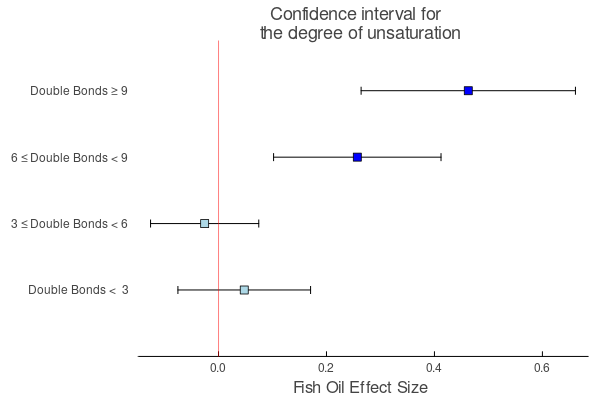

In [20]:
begin
if [slct2] ⊆ ["factor(Total C, Total DB)"]
	idx = 2

    # Carbon
    namesZtc =dict_namesZ["factor(Total C)"];

    CoefZtc, CIZtc, TstatZtc, varZtc = getCoefs(
                                        df,
                                        Matrix{Float64}(dfZ["factor(Total C)"]),
                                        responseSelection = dfZraw.lipID,
                                        isunpaired = isunpairFlag,
                                        hasFishOil = hasFishOil,
                                        is4ways = is4ways
                                        );
    # Double bonds
    namesZdb =dict_namesZ["factor(Total DB)"];

    CoefZdb, CIZdb, TstatZdb, varZdb = getCoefs(
                                        df,
                                        Matrix{Float64}(dfZ["factor(Total DB)"]),
                                        responseSelection = dfZraw.lipID,
                                        isunpaired = isunpairFlag,
                                        hasFishOil = hasFishOil,
                                        is4ways = is4ways
                                        );
    # Join results
    namesZtcdb = vcat(namesZtc[2:end], namesZdb[2:end])
    CoefZtcdb  = hcat(CoefZtc[:, 2:end] , CoefZdb[:, 2:end])
    CIZtcdb    = hcat(CIZtc[:, 2:end] , CIZdb[:, 2:end])
    TstatZtcdb = hcat(TstatZtc[:, 2:end] , TstatZdb[:, 2:end])
    varZtcdb   = hcat(varZtc[:, 2:end] , varZdb[:, 2:end])

    # p_ci_tcdb = confidenceplot(
    #                 CoefZtcdb[idxColXmatCI, :],
    #                 namesZtcdb,
    #                 CIZtcdb[idxColXmatCI, :],
    #                 xlabel = namesX[idxColXmatCI]*" Effect Size", legend = false,
    #                 fontfamily = myfont,
    #                 title = string("Unadjusted") ,
    #                 titlefontsize = mytitlefontsize,
    #                 yaxis = false,
    #                 left_margin = -10mm,
    #                 # size=(800,700),
    #             )
    # p_ci_2 = confidenceplot(
    #             CoefZ[idxColXmatCI, idx:end],
    #             namesZ[idx:end],
    #             CIZ[idxColXmatCI,idx:end],
    #             xlabel = namesX[idxColXmatCI]*" Effect Size", legend = false,
    #             fontfamily = myfont,
    #             title = string("Adjusted") ,
    #             titlefontsize = mytitlefontsize,
    #             right_margin = -20mm,
    #             # size=(800,700),
    # )

    p_ci_unadjusted = confidenceplot(
                    CoefZtcdb[idxColXmatCI, :],
                    namesZtcdb,
                    CIZtcdb[idxColXmatCI, :],
                    xlabel = namesX[idxColXmatCI]*" Effect Size", legend = false,
                    fontfamily = myfont,
                    title = string("Unadjusted") ,
                    titlefontsize = mytitlefontsize,
                    yaxis = true,
                    right_margin = -10mm,
                    # size=(800,700),
                )
    p_ci_adjusted = confidenceplot(
                CoefZ[idxColXmatCI, idx:end],
                namesZ[idx:end],
                CIZ[idxColXmatCI,idx:end],
                xlabel = namesX[idxColXmatCI]*" Effect Size", legend = false,
                fontfamily = myfont,
                title = string("Adjusted") ,
                titlefontsize = mytitlefontsize,
                yaxis = false,
                left_margin = -20mm,
                # size=(800,700),
    )


    # plot(p_ci_2, p_ci_tcdb, size = (750, 500))
    p_ua = plot(p_ci_unadjusted, p_ci_adjusted, size = (750, 500))

	# save in png
	#png(p_ua,string(
	#		    "../images/statin_mlmCI_unadjusted_",
	#		    "_",
	#		    replace(classZ[slct2], " "=> "_"),
	#		    ".png"
	#		 )
	#)

	# save in svg
    #savefig(string(
	#		    "../images/statin_mlmCI_unadjusted_",
	#		    replace(namesX[idxColXmatCI], " "=> "_"),
	#		    "_",
	#		    replace(classZ[slct2], " "=> "_"),
	#		    ".svg"
	#		)
	#)

    # plot(p_ci_2, p_ci_tcdb, size = (750, 500))
    plot(p_ci_unadjusted, p_ci_adjusted, size = (750, 500))
else
	if [slct2] ⊆ ["factor(Total C)", "factor(Total DB)"]
		idx = 1
	else
		idx = 2
	end

	p_ci = confidenceplot(
			CoefZ[idxColXmatCI, idx:end],
			namesZ[idx:end],
			CIZ[idxColXmatCI,idx:end],
			xlabel = namesX[idxColXmatCI]*" Effect Size", legend = false,
			fontfamily = myfont,
			title = string("Confidence interval for \n the ", classZ[slct2]) ,
			titlefontsize = mytitlefontsize,
			# size=(800,700),
	)
	#savefig(string(
	#	"../images/statin_mlmCI_",
	#	replace(namesX[idxColXmatCI], " "=> "_"),
	#	"_",
	#	replace(classZ[slct2], " "=> "_"),
	#	".svg"))
	plot(p_ci)

end
end

In [21]:
begin
	dfCIval = DataFrame(
			Variables = namesZ[idx:end],
		    Coeffecient = round.(CoefZ[idxColXmatCI, idx:end], digits=3),
			L = round.(CoefZ[idxColXmatCI, idx:end] - CIZ[idxColXmatCI,idx:end], digits=3),
			H = round.(CoefZ[idxColXmatCI, idx:end] + CIZ[idxColXmatCI,idx:end], digits =3),
			  )
	# header = ([ "L", "H"])
	# mData = hcat(
	# 	round.(CoefZ[idxColXmatCI, idx:end] - CIZ[idxColXmatCI,idx:end], digits=3),
	# 	round.(CoefZ[idxColXmatCI, idx:end] + CIZ[idxColXmatCI,idx:end], digits =3),
	# 		)
	# DataFrames.PrettyTables.pretty_table(mData, backend = Val(:latex), header = header)

	dfCIval
end;

In [22]:
begin
	if ((slct2 == "factor(Oxidation)") | (slct2 == "factor(Plasmalogen)"))
		if slct2 == "factor(Oxidation)"
			isOxi = true
		else
			isOxi = false
		end

	dfCatego = DataFrame(Catego = ifelse(isOxi, dfZraw.Oxidation, dfZraw.Plasmalogen),
                Effect  = CoefZI[idxColXmatCI,:],
                Tstats  = TstatZI[idxColXmatCI,:]);

	@df dfCatego violin(string.(:Catego),:Effect , linewidth=0, legend = false,
    	xlabel = classZ[slct2],
		ylabel = string("Effect Size of ",namesX[idxColXmatCI]),
		grid = false,
    	title = string("Violin plot of effect size of ", namesX[idxColXmatCI],
				" \naccording to ",	classZ[slct2]," for the triglycerides"))
	end
# savefig(string("../../images/violinOxyCoef_",namesX[idxRow],".svg"))
end

In [23]:
begin
	if ((slct2 == "factor(Oxidation)") | (slct2 == "factor(Plasmalogen)"))

	@df dfCatego violin(string.(:Catego),:Tstats , linewidth=0, legend = false,
    	xlabel = classZ[slct2],
		ylabel = string("Effect Size of ",namesX[idxColXmatCI]),
		grid = false,
    	title = string("Violin plot of T-statistics of ", namesX[idxColXmatCI],
				" \naccording to ",	classZ[slct2]," for the triglycerides"))
		# savefig(string("../../images/violinOxyTstats_",namesX[idxRow],".svg"))
	end
end

In [24]:
function getXYMat(dfInput::DataFrame, Zin::Array{Float64,2}; 
    responseSelection = [""],
    isunpaired::Bool = true, 
    hasFishOil::Bool = true, is4ways = false)

###########
# X and Y #
###########
# responseSelection = intersect(names(dfInput), responseSelection) 
if hasFishOil
if is4ways
dfX, dfY =  getXY4ways(dfInput; responseSelection = responseSelection, isunpaired = isunpaired)
else
dfX, dfY =  getXY(dfInput, responseSelection = responseSelection, isunpaired = isunpaired)
end
else
dfX, dfY =  getXYnoFishOil(dfInput, responseSelection = responseSelection, isunpaired = isunpaired)
end
X = Matrix(dfX);
Y = Matrix(dfY);

return X, Y 
end

getXYMat (generic function with 1 method)

In [25]:
Xmat, Ymat = getXYMat(df, ZI, responseSelection = dfZraw.lipID, isunpaired = isunpairFlag, hasFishOil = hasFishOil,is4ways = is4ways);

In [26]:
"""
Split rows of Y (n×m) and X (n×p) into train/test.

Returns:
  (Y_tr, X_tr, Y_te, X_te, idx_tr, idx_te)
"""
function train_test_split_rows(Y, X; train_frac=0.70, seed=1234, shuffle=true)
    n = size(Y, 1)
    @assert size(X, 1) == n "X and Y must have the same number of rows (individuals)."

    rng = MersenneTwister(seed)
    idx = collect(1:n)
    if shuffle
        Random.shuffle!(rng, idx)
    end

    n_tr = floor(Int, train_frac * n)
    idx_tr = idx[1:n_tr]
    idx_te = idx[n_tr+1:end]

    Y_tr = @view Y[idx_tr, :]
    X_tr = @view X[idx_tr, :]
    Y_te = @view Y[idx_te, :]
    X_te = @view X[idx_te, :]

    return (Y_tr, X_tr, Y_te, X_te, idx_tr, idx_te)
end

# ---- run split COPD Data ----
Y_tr, X_tr, Y_te, X_te, idx_tr, idx_te =
    train_test_split_rows(Ymat, Xmat; train_frac=0.70, seed=5)

@show size(Y_tr) size(X_tr) size(Y_te) size(X_te)
@show length(idx_tr) length(idx_te)

size(Y_tr) = (68, 770)
size(X_tr) = (68, 4)
size(Y_te) = (30, 770)
size(X_te) = (30, 4)
length(idx_tr) = 68
length(idx_te) = 30


30

In [27]:
samsZsp_tr = mlm(RawData(Response(Y_tr), Predictors(X_tr, ZI)), addXIntercept=false, addZIntercept=false)

Mlm([0.036887775793232824 -0.10126214132566856 … 0.21139974204525966 0.006520850036728044; 0.06764407434759227 0.04534290213567259 … -0.12964047410031182 -0.0901606241680912; 0.14817340530555398 -0.2240849893778585 … 0.6160600138982023 0.1481449861388181; 0.06790915243509582 0.02434060337018311 … 0.14243197930132973 -0.06416740345891375], [0.015483876486739634 0.020937147843196093 … 0.013168510577205651 0.01896924647548533; 0.015483876486739634 0.020937147843196093 … 0.013168510577205651 0.01896924647548533; 0.015483876486739632 0.02093714784319609 … 0.01316851057720565 0.018969246475485327; 0.015483876486739632 0.02093714784319609 … 0.01316851057720565 0.018969246475485327], [0.838116243792932 0.16084371864993083 … -0.017445738791723325 0.166273411544937; 0.16084371864993083 1.1332926687386504 … 0.011880856666325683 0.2666148564356521; … ; -0.017445738791723325 0.011880856666325683 … 0.7127893735633285 0.005628972379705651; 0.166273411544937 0.2666148564356521 … 0.005628972379705651 1

In [28]:
samsZsp_coef_tr = MatrixLM.coef(samsZsp_tr)

4×770 Matrix{Float64}:
 0.0368878  -0.101262   -0.0494     …   0.269638    0.2114     0.00652085
 0.0676441   0.0453429   0.186766      -0.0619717  -0.12964   -0.0901606
 0.148173   -0.224085   -0.0499868      0.667037    0.61606    0.148145
 0.0679092   0.0243406   0.089187       0.134934    0.142432  -0.0641674

In [29]:
samsZsp_tstat_tr = MatrixLM.t_stat(samsZsp_tr)

4×770 Matrix{Float64}:
 0.296444  -0.699823  -0.383639  …   2.70489    1.8422    0.0473456
 0.543613   0.313365   1.45042      -0.621672  -1.12972  -0.654624
 1.19078   -1.54865   -0.388196      6.69142    5.36852   1.07563
 0.545743   0.168218   0.692623      1.3536     1.24119  -0.465896

In [30]:
samsZsp_se_tr = abs.(samsZsp_coef_tr ./ samsZsp_tstat_tr)

4×770 Matrix{Float64}:
 0.124434  0.144697  0.128767  0.1284  …  0.0996855  0.114754  0.137729
 0.124434  0.144697  0.128767  0.1284     0.0996855  0.114754  0.137729
 0.124434  0.144697  0.128767  0.1284     0.0996855  0.114754  0.137729
 0.124434  0.144697  0.128767  0.1284     0.0996855  0.114754  0.137729

In [31]:
# Gibbs Sampler for one level Bayesian Hierarchical Model

function gibbs_meta_hier_traces_db(
    b_obs::Vector{Float64},           # length m
    se_obs::Vector{Float64},          # length m
    subclass_of_met::Vector{Int},     # length m, values in 1..H (Total DB class)
    H::Int;                           # number of DB categories
    mu0::Float64 = 0.0,
    s0::Float64 = 1.0,
    halfcauchy_scale::Float64 = 1.0,
    n_iter::Int = 2000,
    burnin::Int = 500,
    thin::Int = 1,
    seed::Int = 1234,
)
    @assert length(b_obs) == length(se_obs) "b_obs and se_obs must have same length"
    @assert length(subclass_of_met) == length(b_obs) "subclass_of_met must have length m"
    @assert maximum(subclass_of_met) == H "subclass_of_met must be in 1..H"
    @assert burnin < n_iter "burnin must be < n_iter"
    @assert thin ≥ 1

    Random.seed!(seed)
    m = length(b_obs)
    lam_j = 1.0 ./ (se_obs .^ 2)  # observation precisions

    # --- initialize state ---
    theta = copy(b_obs)                                     # length m (metabolite-level effects)
    beta  = [mean(theta[subclass_of_met .== h]) for h in 1:H]  # class means
    theta0 = mean(beta)                                     # global mean over classes

    tau_w2 = 1.0   # within-class variance for theta_j | beta_h
    tau_v2 = 1.0   # between-class variance for beta_h | theta0

    lambda_w = 1.0    # IG mixture auxiliaries for half-Cauchy
    lambda_v = 1.0

    # --- precompute group indices ---
    idx_by_sub = [findall(==(h), subclass_of_met) for h in 1:H]

    # --- storage sizes ---
    n_keep = floor(Int, (n_iter - burnin) ÷ thin)

    # scalars per draw (for quick monitoring)
    draws_scalar = DataFrame(
        theta0 = Vector{Float64}(undef, n_keep),
        tau_w2 = Vector{Float64}(undef, n_keep),
        tau_v2 = Vector{Float64}(undef, n_keep),
    )

    # vectors per draw
    beta_draws  = Array{Float64}(undef, H, n_keep)   # columns = kept iters
    theta_draws = Array{Float64}(undef, m, n_keep)

    keep_idx = 0

    for it in 1:n_iter
        #######################
        # 1) update theta_j   #
        #######################
        for j in 1:m
            h = subclass_of_met[j]
            lik_prec   = lam_j[j]
            lik_sum    = lam_j[j] * b_obs[j]
            prior_prec = 1.0 / tau_w2
            prior_mean = beta[h]
            mean_th = (lik_sum + prior_prec * prior_mean) / (lik_prec + prior_prec)
            var_th  = 1.0 / (lik_prec + prior_prec)
            theta[j] = rand(Normal(mean_th, sqrt(var_th)))
        end

        #######################
        # 2) update beta_h    #
        #######################
        for h in 1:H
            J = idx_by_sub[h]
            mh = length(J)

            # likelihood: theta_j | beta_h ~ N(beta_h, tau_w2)
            lik_prec   = mh / tau_w2
            lik_sum    = (1.0 / tau_w2) * sum(theta[J])

            # prior: beta_h | theta0 ~ N(theta0, tau_v2)
            prior_prec = 1.0 / tau_v2
            prior_mean = theta0

            mean_b = (lik_sum + prior_prec * prior_mean) / (lik_prec + prior_prec)
            var_b  = 1.0 / (lik_prec + prior_prec)
            beta[h] = rand(Normal(mean_b, sqrt(var_b)))
        end

        #######################
        # 3) update theta0    #
        #######################
        # beta_h | theta0 ~ N(theta0, tau_v2)
        lik_prec   = H / tau_v2
        lik_sum    = (1.0 / tau_v2) * sum(beta)

        # prior: theta0 ~ N(mu0, s0^2)
        prior_prec = 1.0 / (s0^2)
        prior_mean = mu0

        mean_t0 = (lik_sum + prior_prec * prior_mean) / (lik_prec + prior_prec)
        var_t0  = 1.0 / (lik_prec + prior_prec)
        theta0  = rand(Normal(mean_t0, sqrt(var_t0)))

        ############################################
        # 4) update tau_w2 and tau_v2 via IG mix   #
        ############################################

        # tau_w2: within-class spread of theta_j around beta_{class(j)}
        ssw = sum((theta .- beta[subclass_of_met]).^2)
        tau_w2   = rand(InverseGamma((m + 1.0) / 2.0, 0.5 * ssw + 1.0 / lambda_w))
        lambda_w = rand(InverseGamma(1.0, 1.0 / (halfcauchy_scale^2) + 1.0 / tau_w2))

        # tau_v2: between-class spread of beta_h around theta0
        ssv = sum((beta .- theta0).^2)
        tau_v2   = rand(InverseGamma((H + 1.0) / 2.0, 0.5 * ssv + 1.0 / lambda_v))
        lambda_v = rand(InverseGamma(1.0, 1.0 / (halfcauchy_scale^2) + 1.0 / tau_v2))

        ###################################
        # 5) store post-burn (with thin) #
        ###################################
        if it > burnin && ((it - burnin) % thin == 0)
            keep_idx += 1
            draws_scalar.theta0[keep_idx] = theta0
            draws_scalar.tau_w2[keep_idx] = tau_w2
            draws_scalar.tau_v2[keep_idx] = tau_v2

            beta_draws[:, keep_idx]  .= beta
            theta_draws[:, keep_idx] .= theta
        end
    end

    return (; draws_scalar,
            beta_draws,
            theta_draws,
            last_state = (; theta0, tau_w2, tau_v2,
                          beta = copy(beta), theta = copy(theta)))
end

gibbs_meta_hier_traces_db (generic function with 1 method)

In [32]:
"""
Given theta_draws (m × n_keep), return:
  mean_theta :: Vector{Float64} length m
  sd_theta   :: Vector{Float64} length m
"""
function summarize_theta_draws(theta_draws::AbstractMatrix{<:Real})
    m, n_keep = size(theta_draws)
    mean_theta = vec(mean(theta_draws; dims=2))
    sd_theta   = vec(std(theta_draws; dims=2, corrected=true))
    return mean_theta, sd_theta
end

summarize_theta_draws

In [33]:
"""
Run Gibbs meta-hierarchy for each covariate (row of B_obs/SE_obs).

Returns:
  B_bayes  :: Matrix{Float64}  (p×m) posterior means
  SE_bayes :: Matrix{Float64}  (p×m) posterior SDs   (NOT frequentist SEs)
  res_list :: Vector           results per covariate (optional to keep)
"""
function fit_bayes_all_covariates(
    B_obs::AbstractMatrix{<:Real},          # p×m
    SE_obs::AbstractMatrix{<:Real},         # p×m
    subclass_of_met::Vector{Int},
    H::Int;
    mu0::Float64 = 0.0,
    s0::Float64 = 1.0,
    halfcauchy_scale::Float64 = 1.0,
    n_iter::Int = 5000,
    burnin::Int = 1000,
    thin::Int = 1,
    seed0::Int = 42,
    keep_results::Bool = false
)
    p, m = size(B_obs)
    @assert size(SE_obs) == (p, m) "SE_obs must have same shape as B_obs"

    B_bayes  = Array{Float64}(undef, p, m)
    SE_bayes = Array{Float64}(undef, p, m)

    res_list = keep_results ? Vector{Any}(undef, p) : Any[]

    for k in 1:p
        b_vec  = vec(Float64.(B_obs[k, :]))
        se_vec = vec(Float64.(SE_obs[k, :]))

        #mu0 = mu0_mode === :empirical ? mean(b_vec) : 0.0

        res_k = gibbs_meta_hier_traces_db(
            b_vec, se_vec, subclass_of_met, H;
            mu0 = mu0, s0 = s0,
            halfcauchy_scale = halfcauchy_scale,
            n_iter = n_iter, burnin = burnin, thin = thin,
            seed = seed0 + k
        )

        @assert res_k.theta_draws !== nothing "theta_draws missing; ensure save_theta=true"

        mean_theta, sd_theta = summarize_theta_draws(res_k.theta_draws)

        # store into row k
        @inbounds begin
            B_bayes[k, :]  .= mean_theta
            SE_bayes[k, :] .= sd_theta
        end

        if keep_results
            res_list[k] = res_k
        end

        println("Done covariate k=$k / $p")
    end

    return B_bayes, SE_bayes, res_list
end

fit_bayes_all_covariates

In [34]:
B_bayes_tr, SE_bayes_tr, res_by_cov =
    fit_bayes_all_covariates(
        samsZsp_coef_tr, samsZsp_se_tr,
        cat_DB_idx, length(unique(cat_DB_idx));
        mu0 = 0.0,      
        s0 = 1.0,
        n_iter = 5000, burnin = 1000, thin = 1,
        seed0 = 1000,
        keep_results = false
    )

@show size(B_bayes_tr) size(SE_bayes_tr)

Done covariate k=1 / 4
Done covariate k=2 / 4
Done covariate k=3 / 4
Done covariate k=4 / 4
size(B_bayes_tr) = (4, 770)
size(SE_bayes_tr) = (4, 770)


(4, 770)

In [35]:
"""
Predict Yhat and compute MSE summaries.

Inputs
  Y_te :: (n_te × m) matrix
  X_te :: (n_te × p) matrix
  B    :: (p × m) coefficient matrix

Returns
  mse_all :: Float64
  mse_met :: Vector{Float64} length m   (MSE per metabolite)
  mse_ind :: Vector{Float64} length n_te (MSE per individual)
"""
function test_mse(Y_te::AbstractMatrix{<:Real},
                  X_te::AbstractMatrix{<:Real},
                  B::AbstractMatrix{<:Real})

    n_te, m = size(Y_te)
    @assert size(X_te, 1) == n_te "X_te and Y_te must have same number of rows"
    p = size(X_te, 2)
    @assert size(B) == (p, m) "B must be p×m with p=size(X_te,2), m=size(Y_te,2)"

    # predictions
    Yhat = X_te * B                       # n_te × m
    R = Y_te .- Yhat                      # residuals

    mse_all = mean(abs2, R)               # overall mean squared error
    mse_met = vec(mean(abs2, R; dims=1))  # average over individuals -> per metabolite
    mse_ind = vec(mean(abs2, R; dims=2))  # average over metabolites -> per individual

    return mse_all, mse_met, mse_ind
end

test_mse

In [36]:
# Ensure Float64 (optional but avoids mixed types)
Y_te_f = Float64.(Y_te)
X_te_f = Float64.(X_te)

B_mlm  = Float64.(samsZsp_coef_tr)
B_bys  = Float64.(B_bayes_tr)

mse_mlm, mse_mlm_met, mse_mlm_ind = test_mse(Y_te_f, X_te_f, B_mlm)
mse_bys, mse_bys_met, mse_bys_ind = test_mse(Y_te_f, X_te_f, B_bys)

println("Test MSE (MatrixLM): ", mse_mlm)
println("Test MSE (Bayes):    ", mse_bys)
println("Relative improvement (positive is better): ",
        (mse_mlm - mse_bys) / mse_mlm)

Test MSE (MatrixLM): 1.134253774337758
Test MSE (Bayes):    1.0932373171710759
Relative improvement (positive is better): 0.03616162281728352
